# Usage of `src.analysis.weather_interpolator` module.

This notebook outlies the basic usage of the `src.analysis.weather_interpolator` module. Used to interpolate weather conditions at any time, lon, lat, and elevation.
 
**Requirements**
 - A csv with weather station data for the whole country for a given time interval
 
**Helpful Links**


## Basic Setup

In [1]:
import sys
# This variable should indicate the path from this Jupyter Notebook to the root directory of the repo.
root_path = '../'
# Adds the repo's root to the list of paths
sys.path.append(root_path)

# Package to read yml files
import yaml
# Package to handle file paths
import os
# Package to deal with DataFrames
import pandas as pd
# Package to plot stuff
import matplotlib.pyplot as plt
# Package for numerical and array handling
import numpy as np

# Function to clear output from jupyter notebook
from IPython.display import clear_output
# Package for compressing dataframes into file
from src.data import compressors
# Package for defining and fitting weather models
from src.models import weather
# Utilities package
from src.common import utils
# Package for interpolating and estimating weather
from src.analysis import weather_interpolator

root_path = os.path.normpath(root_path) # Path from this notebook to the root directory
config_path_from_root = os.path.normpath('config/config_tutorial.yml') # Path from root to the desired config file
config_path = os.path.join(root_path, config_path_from_root) # Defining path from this notebook to config file

# Loading config file
with open(config_path, 'r',  encoding='utf8') as file:
    config = yaml.safe_load(file)

# Defining "clear-output" function to feed into logger
def clear():
    clear_output(wait=True)

# Creates an instance of a logger class to log all that happens, optional (but encouraged).
logger = utils.Logger(config, clear_function=None)

# Creates an isntance of the CsvCompressor
compressor = compressors.CsvCompressor(config, logger=logger)

# Creates an instance of the weather interpolator
interpolator = weather_interpolator.WeatherInterpolator(config, logger=logger)

# Defining location of data
data_directory = 'tutorial_data'

# Loading weather station data
all_stations_data = pd.read_csv(os.path.join(data_directory, 'all_stations_data.csv'), index_col = 0)

# Loading flight state_vectors
state_vectors = compressor.decode_to_dataframe_from_file(os.path.join(data_directory, 'state_vectors_compressed.csv'))

2023/11/08 14:57:11 : CSV Decoding data from tutorial_data/state_vectors_compressed.csv


## Interpolating weather at specific time, lat, lon, and elevation

By Default, the interpolator will look for data in the weather's out-dir as specified in the config file, unless it's given one directly.

The interpolator will also calibrate the weather data, unless specified that it has already beed calibrated as an argument

Weather model calibration happens inside the estimation function.

Target needs to be a dictionary with the necessary parameters, in this case we'll use the avegate values form the weather stations info

## Estimating scalar at given target location and time

In [2]:
target = {'lon': all_stations_data['lon'].mean(),
         'lat': all_stations_data['lat'].mean(),
         'timestamp': all_stations_data['timestamp'].mean(),
         'elevation': all_stations_data['elevation'].mean(),
         }

In [3]:

interpolator.estimate_scalars(target, ['tmpf'], stations_data=all_stations_data)


array([31.62074063])

In [4]:

interpolator.estimate_scalars(target, ['air_pressure'], stations_data=all_stations_data)


array([967.59686566])

In [5]:

interpolator.estimate_scalars(target, ['air_density'], stations_data=all_stations_data)


array([1.23501164])

In [6]:

interpolator.estimate_scalars(target, ['clouds'], stations_data=all_stations_data)


array([0.])

In [7]:

interpolator.estimate_scalars(target, ['tmpf', 'air_pressure', 'air_density', 'clouds'], stations_data=all_stations_data)


array([ 31.62074063, 967.59686566,   1.23501164,   0.        ])

In [8]:

sv = compressor.decode_to_dataframe_from_file('../data/flight/KLAX_KSFO/state_vectors/71be29_1674543810_1674547109_KLAX_KSFO.csv')


2023/11/08 14:57:14 : CSV Decoding data from ../data/flight/KLAX_KSFO/state_vectors/71be29_1674543810_1674547109_KLAX_KSFO.csv


<Axes: >

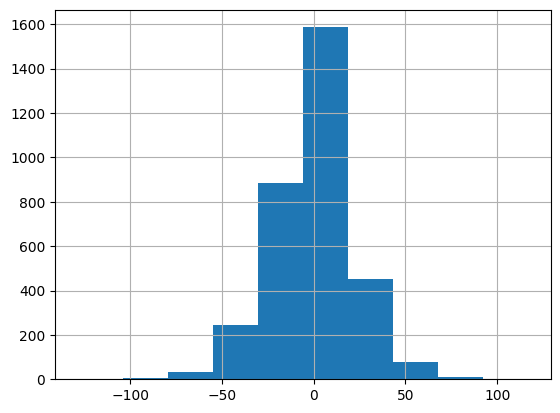

In [14]:
interpolator.estimate_flight_wind(sv)['wind_velocity_heading'].hist()

In [10]:
state_vectors

,time,lat,lon,baroaltitude,geoaltitude,heading,velocity
0,1672504541,30.524768,-91.141534,129.540000,114.300000,132.646703,79.732182
1,1672504542,30.524326,-91.140966,143.955247,132.211482,132.569031,79.451578
2,1672504543,30.523884,-91.140398,158.370494,150.122965,132.491359,79.170974
3,1672504544,30.523442,-91.139830,172.785741,168.034447,132.413687,78.890370
4,1672504545,30.522991,-91.139252,187.259299,185.829308,132.373855,78.688947
...,...,...,...,...,...,...,...
3821,1672508362,32.931543,-97.054576,319.259110,276.463525,180.839266,70.019598
3822,1672508363,32.930925,-97.054582,315.719012,271.020988,180.751338,69.970721
3823,1672508364,32.930314,-97.054586,312.079341,267.040659,180.641321,69.969239
3824,1672508365,32.929703,-97.054591,308.439671,263.060329,180.531303,69.967757


In [11]:
# %%time
# scalars = ['tmpf', 'air_pressure', 'air_density', 'clouds']
# scalar_values = {scalar: np.repeat(np.nan, len(state_vectors)) for scalar in scalars}
# step = config['statistics']['interpolation']['flights']['step']
# for i, row in state_vectors.iloc[::step].iterrows():
#     clear()
#     print(f'{i}/{len(state_vectors)}')
#     target = {
#         'lon': row['lon'],
#         'lat': row['lat'],
#         'timestamp': row['time'],
#         'elevation': row['geoaltitude'],
#          }
#     values = interpolator.estimate_scalars(target, scalars, stations_data=all_stations_data)
#     for j, scalar in enumerate(scalars):
#         scalar_values[scalar][i] = values[j]
# for scalar in scalars:
#     state_vectors[scalar] = scalar_values[scalar]
#     state_vectors[scalar] = state_vectors[scalar].interpolate(method='linear')

# state_vectors

<Axes: >

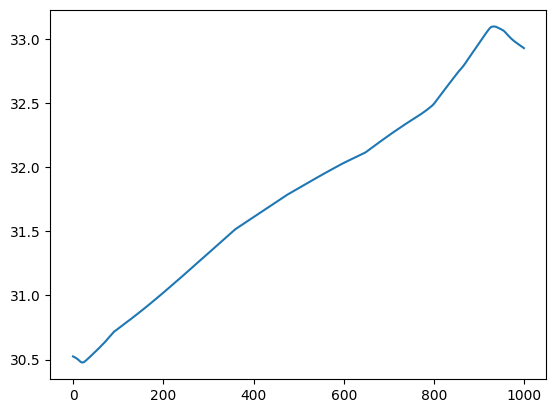

In [12]:
compressed = pd.read_csv('tutorial_data/state_vectors_compressed.csv', index_col = 0)
compressed['lat'].plot()